
# Deep Learning Homework 6

This code is provided for Deep Learning class (601.482/682) Homework 6. For ease of implementation, we recommend working entire in Google Colaboratory.

@Copyright Hao Ding, Cong Gao, the Johns Hopkins University, hding15@jhu.edu, cgao11@jhu.edu.

Modifications made by Hongtao Wu, Suzanna Sia, Hao Ding, Keith Harrigian, and Yiqing Shen.

# Problem 1: Unsupervised Pre-training

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np                # Numpy for array manipulation for ease of access
import torch                      # Pytorch for array manipulation on the GPU and nice deep learning functions
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2
# Image import and display libraries                       # OpenCV for image processing
import matplotlib.pyplot as plt   # Plotting functions
%matplotlib inline

# Image processing libraries for image feature extractor
from scipy.stats import kurtosis, skew
from scipy.ndimage.filters import generic_filter
from skimage.filters import laplace, gabor
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.preprocessing import scale

# A few more tools
from sklearn import svm           # SVM classifier library
import os                         # Navigate through directories
import csv                        # Read in a CSV file
import time                       # Timing function
import pickle                     # Saving and loading variables

# Mount Google Drive folder as a local folder
# Note: This mounts your entire drive, not the current folder
from google.colab import drive
drive.mount('/mydrive')


<ipython-input-1-e07fd3380f13>:19: DeprecationWarning: Please import `generic_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import generic_filter


Mounted at /mydrive


In [ ]:
#TODO replace the path with your path in drive
#This usually takes 5 minutes to run
!cp -r /mydrive/MyDrive/SegSTRONGC_MLDL ./

### Hyperparameters

We provide an initial hyper parameter, feel free to change according to your need.


In [ ]:
#TODO tune your own parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 10
use_gpu = False
if torch.cuda.is_available(): #use gpu if available
  use_gpu = True
  print("using cuda")

using cuda


### Data Loaders

We have provided you with some preprocessing code for the images but you should feel free to modify the class however you please to support your training schema.

In [ ]:
import numpy as np
import os
import os.path as osp
import torch.utils.data as data
import torchvision.transforms as T
from PIL import Image

class SegSTRONGC(data.Dataset):
    def __init__(self, root_folder: str, set_indices: list, subset_indices: list, split: str = 'train', domains: list = ['regular'], image_transforms = None, gt_transforms = None):
        '''
            reference dataset loading for SegSTRONGC
            root_folder: the root_folder of the SegSTRONGC dataset
            set_indices: is the indices for sets to be used
            subset_indices: is the indices for the subsets to be used
            split: 'train', 'val' or 'test'
            domain: the image domains to be loaded.
            image_transforms: any transforms to perform, can add augmentations here.
            gt_transforms: list of bool. Indicates whether image_transforms should also be appleid to gt.
        '''
        self.split = split
        self.root_folder = root_folder
        self.set_indices = set_indices
        self.subset_indices = subset_indices
        self.domains = domains
        self.image_transforms = image_transforms
        self.gt_transforms = gt_transforms

        self.image_paths = []
        self.gt_paths = []

        for set_idx, s in enumerate(self.set_indices):
            for ss in self.subset_indices[set_idx]:
                set_folder = osp.join(self.root_folder, self.split + '/' + str(s) + '/' + str(ss))
                gt_folder = osp.join(set_folder, 'ground_truth')

                for d in self.domains:
                    image_folder = osp.join(set_folder, d)
                    for i in range(300):
                        image_name = str(i) + ".jpg"
                        gt_name = str(i) + ".png"
                        self.image_paths.append(osp.join(image_folder, 'left/' + image_name))
                        self.gt_paths.append(osp.join(gt_folder, 'left/' + gt_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = np.array(Image.open(self.image_paths[idx])).astype(np.float32) / 255
        gt = (np.array(Image.open(self.gt_paths[idx])) / 255).astype(np.int64)
        # Apply transformation to image and ground truth
        if self.image_transforms is not None and self.gt_transforms is not None:
            image = self.image_transforms(image)
            gt = self.gt_transforms(gt)
        else:
            image = T.ToTensor()(image)
            gt = T.ToTensor()(gt)

        return image, gt

## Model Architecture

Finish building the U-net architecture below.

In [ ]:

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    self.conv5   = add_conv_stage(256, 512, useBN=useBN)
    # Upgrade stages
    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)

    ## TODO Design your last layer & activations
    self.final_layer = nn.Sequential(
        nn.Conv2d(32, 1, kernel_size=1),
        nn.Sigmoid()  # For binary segmentation
    )


  def forward(self, x):
    #TODO implement forward function
    x1 = self.conv1(x)
    x2 = self.max_pool(x1)
    x2 = self.conv2(x2)
    x3 = self.max_pool(x2)
    x3 = self.conv3(x3)
    x4 = self.max_pool(x3)
    x4 = self.conv4(x4)
    x5 = self.max_pool(x4)
    x5 = self.conv5(x5)

    x4m = self.upsample54(x5)
    x4m = torch.cat([x4m, x4], dim=1)
    x4m = self.conv4m(x4m)

    x3m = self.upsample43(x4m)
    x3m = torch.cat([x3m, x3], dim=1)
    x3m = self.conv3m(x3m)

    x2m = self.upsample32(x3m)
    x2m = torch.cat([x2m, x2], dim=1)
    x2m = self.conv2m(x2m)

    x1m = self.upsample21(x2m)
    x1m = torch.cat([x1m, x1], dim=1)
    x1m = self.conv1m(x1m)

    output = self.final_layer(x1m)

    return output


Here defines trainning functions, diceloss functions and dice evaluation functions

In [ ]:
def trainning(model, trainning_dataloader, validation_dataloader, num_epochs, criterion, optimizer, filename):
    if use_gpu:
      model.cuda()
    lr_changed = False
    trainning_losses = []
    validation_losses = []
    total_training_loss = 0
    total_val_loss = 0
    total_training_iteration = 0
    total_val_iteration = 0
    for epoch in range(num_epochs):
        i = 0
        model.train()
        for data in trainning_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_training_loss += loss.item()
          loss.backward()
          optimizer.step()
          i = i+1
          total_training_iteration += 1
          if total_training_iteration % 100 == 99:
            trainning_losses.append(total_training_loss / total_training_iteration)
        if epoch % 5 == 4:
            print("learning_rate decayed")
            for param_group in optimizer.param_groups:
              param_group['lr'] *= 0.1
        model.eval()
        for data in validation_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_val_loss += loss.item()
          total_val_iteration += 1
          if total_val_iteration % 100 == 99:
            validation_losses.append(total_val_loss / total_val_iteration)
        print("epoch:",epoch,"training_loss:",total_training_loss / total_training_iteration, "validation_loss:",total_val_loss / total_val_iteration)
        torch.save(model.state_dict(), filename)
    plt.plot(trainning_losses)
    plt.show()
    plt.plot(validation_losses)
    plt.show()

### DICE Score and DICE Loss

Finish implementing the DICE score function below and then write a Dice Loss function that you can use to update your model weights.

In [ ]:
def DICE(model, test_dataloader, smooth=1e-10):
    dice = []
    model.eval()
    for data in test_dataloader:
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        predict = model(img) > 0.5
        num = 2 * (predict * target).sum()
        denum = predict.sum() + target.sum()
        dice.append(((num + smooth) / (denum + smooth)).item())
    m_dice = np.mean(dice)
    return m_dice

def DICELoss(scores, target, smooth=1e-10):
    scores = scores.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (scores * target).sum()

    dice_coeff = (2.0 * intersection + smooth) / (scores.sum() + target.sum() + smooth)

    dice_loss = 1 - dice_coeff

    return dice_loss


define transforms and vanilla dataset for trainning

In [ ]:
root_folder = "./SegSTRONGC_MLDL" #TODO replace with your own path
size = (272, 480)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_set_indices = [3, 4, 5, 7, 8]
train_subset_indices = [[0, 2], [0, 1, 2], [0, 2], [0, 1], [1, 2]]

train_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
train_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_trainning_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms,
    gt_transforms = train_gt_transforms)
segmentation_trainning_dataloader = DataLoader(segmentation_trainning_dataset, batch_size=batch_size, shuffle=True)

val_set_indices = [1]
val_subset_indices = [[0]]

val_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
val_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_validation_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = val_set_indices,
    subset_indices = val_subset_indices,
    split = 'val',
    domains = ['regular'],
    image_transforms = val_image_transforms,
    gt_transforms = val_gt_transforms)

segmentation_validation_dataloader = DataLoader(segmentation_validation_dataset, batch_size=1, shuffle=False)

test_set_indices = [9]
test_subset_indices = [[0]]

test_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
test_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
])
segmentation_test_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['regular'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader = DataLoader(segmentation_test_dataset, batch_size=1, shuffle=False)

segmentation_test_dataset_blood = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['blood'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader_blood = DataLoader(segmentation_test_dataset_blood, batch_size=1, shuffle=False)


In [ ]:
def show_demo(model, test_dataset_loader, num=10):
    model.eval()
    count = 0
    for demo in test_dataset_loader:
        demo_input, demo_target = demo
        if use_gpu:
           demo_input = demo_input.cuda()
        demo_output = model(demo_input)
        for i in range(demo_input.shape[0]):
            plt.subplot(1, 3, 1)
            plt.imshow(demo_input[i].permute(1,2,0).detach().cpu().numpy())
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(demo_output[i].detach().cpu().numpy().squeeze()*255)
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(demo_target[i].detach().numpy().squeeze())
            plt.axis("off")
            plt.show()
        if count >= num:
          break
        count += 1

### Training vanilla model on vanilla dataset

epoch: 0 training_loss: 0.1881474641236392 validation_loss: 0.08408752858638763
epoch: 1 training_loss: 0.11740317624626738 validation_loss: 0.07267537206411362
epoch: 2 training_loss: 0.08985113224597892 validation_loss: 0.06466047995620304
epoch: 3 training_loss: 0.07567275125872006 validation_loss: 0.07241719499230385
learning_rate decayed
epoch: 4 training_loss: 0.06604910550695477 validation_loss: 0.07073180341720581
epoch: 5 training_loss: 0.058973494021579476 validation_loss: 0.06986295110649533
epoch: 6 training_loss: 0.05377356495176043 validation_loss: 0.06878184443428403
epoch: 7 training_loss: 0.04978759948051337 validation_loss: 0.06944588412841161
epoch: 8 training_loss: 0.046616836870559536 validation_loss: 0.06962880297943398
learning_rate decayed
epoch: 9 training_loss: 0.044017101417888296 validation_loss: 0.06953075848023096


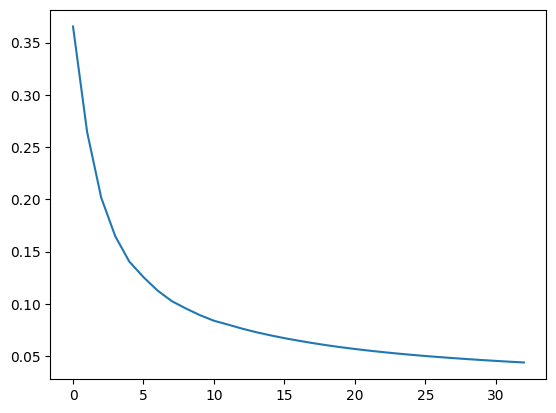

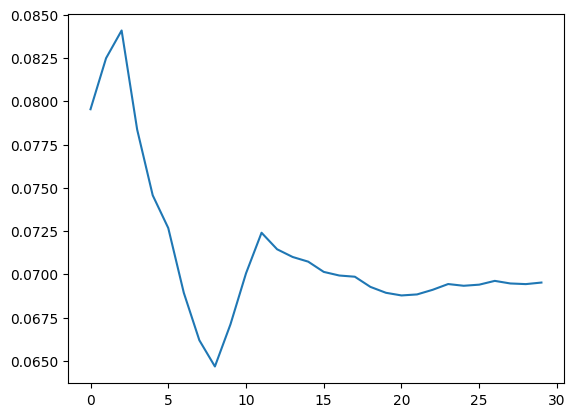

In [ ]:
segmentation_model = unet(useBN=True)
dice_criterion = DICELoss
segmentation_optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainning(segmentation_model, segmentation_trainning_dataloader, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer, "final_vanilla_model.pth")

<ipython-input-11-e3cc487ca1f9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))


0.946856356660525


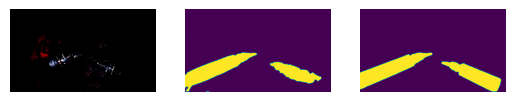

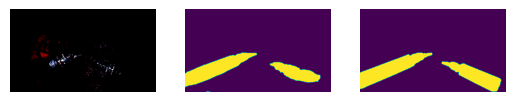

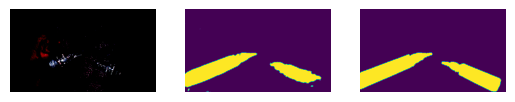

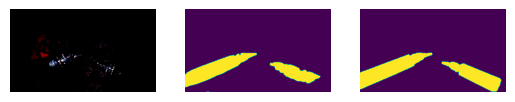

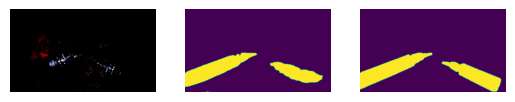

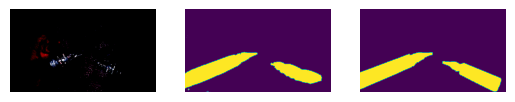

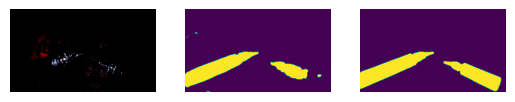

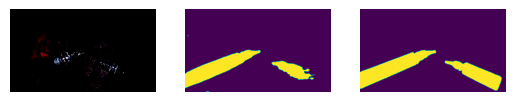

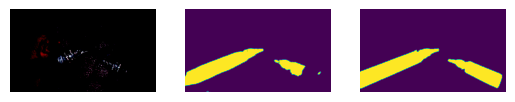

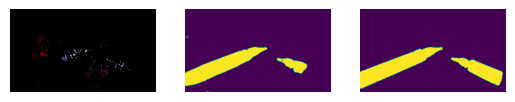

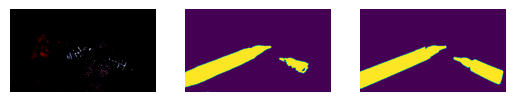

In [ ]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
print(DICE(segmentation_model, segmentation_test_dataloader))
show_demo(segmentation_model, segmentation_test_dataloader)

<ipython-input-12-22fdffdb8f9a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))


0.4579842975238959


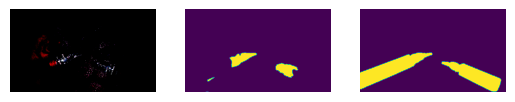

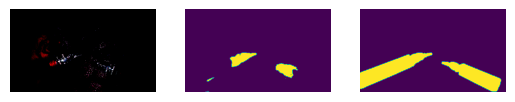

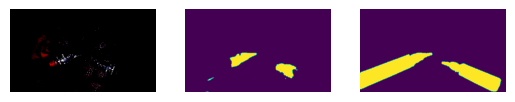

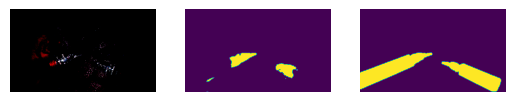

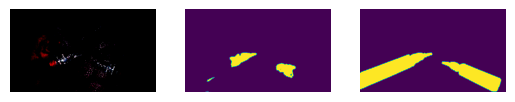

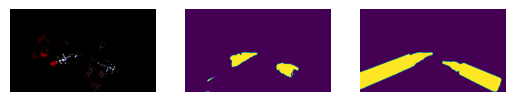

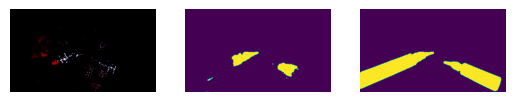

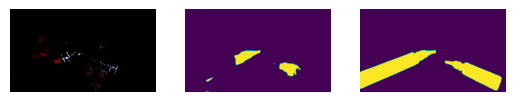

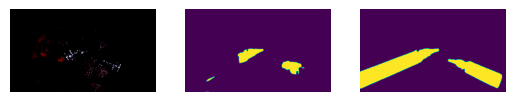

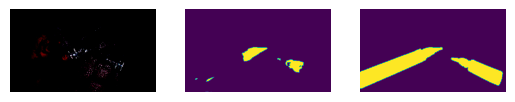

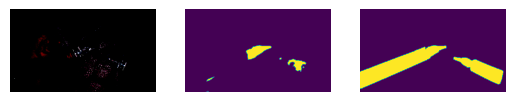

In [ ]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
print(DICE(segmentation_model, segmentation_test_dataloader_blood))
show_demo(segmentation_model, segmentation_test_dataloader_blood)

### Do data augmentation for better trainning  

Think about what data augmentations you would like to use to help with blood situation.

In [ ]:
import torch
import torchvision.transforms as transforms

class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

#TODO add transformations in training dataset,
# Carefully think about whether the it is suitable for segmentation task
train_image_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, shear=5),
    AddGaussianNoise(mean=0.0, std=0.05),
    transforms.Normalize(mean=mean, std=std)
])

train_gt_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=10, shear=5)
])
segmentation_trainning_dataset_augmented = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms_augmented,
    gt_transforms = train_gt_transforms_augmented)
segmentation_trainning_dataloader_augmented = DataLoader(segmentation_trainning_dataset_augmented, batch_size=batch_size, shuffle=True)

Retrain with augmented dataset

epoch: 0 training_loss: 0.5602056127606017 validation_loss: 0.4257135597864787
epoch: 1 training_loss: 0.5446448519374385 validation_loss: 0.32245216975609464
epoch: 2 training_loss: 0.5404869168695777 validation_loss: 0.327282186349233
epoch: 3 training_loss: 0.5379829928730473 validation_loss: 0.3172470360000928
learning_rate decayed
epoch: 4 training_loss: 0.5355599914536332 validation_loss: 0.3274503129720688
epoch: 5 training_loss: 0.5331691496299975 validation_loss: 0.3189323242836528
epoch: 6 training_loss: 0.5311285928472296 validation_loss: 0.32008788361435847
epoch: 7 training_loss: 0.5288941314726164 validation_loss: 0.3182662359128396
epoch: 8 training_loss: 0.5274377152373895 validation_loss: 0.3165917949102543
learning_rate decayed
epoch: 9 training_loss: 0.5256822571609959 validation_loss: 0.3129682613015175


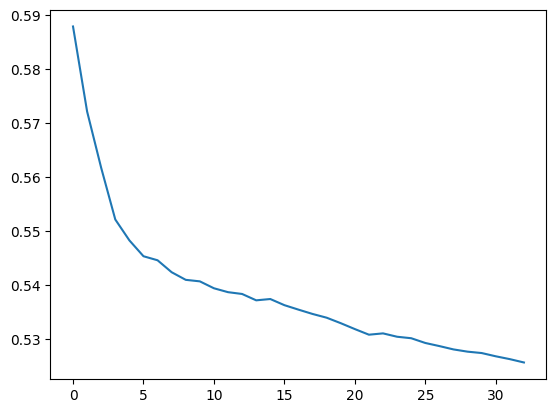

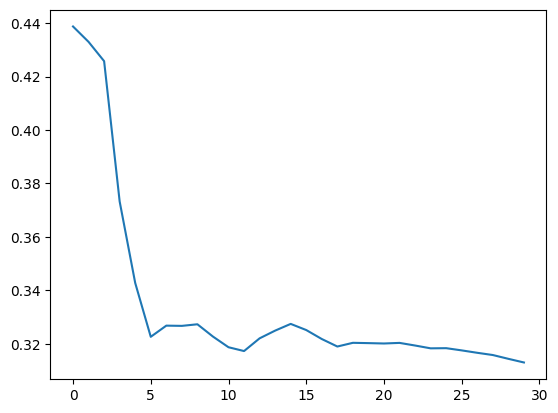

In [ ]:
segmentation_model_augmented = unet(useBN=True)
dice_criterion = DICELoss
segmentation_optimizer_augmented = torch.optim.Adam(segmentation_model_augmented.parameters(), lr=learning_rate, weight_decay=1e-4)
trainning(segmentation_model_augmented, segmentation_trainning_dataloader_augmented, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer_augmented, "final_augmented_model.pth")

<ipython-input-29-5f017138d64a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))


0.7369166298707326


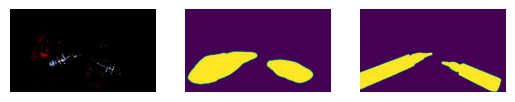

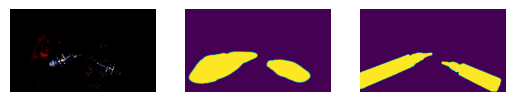

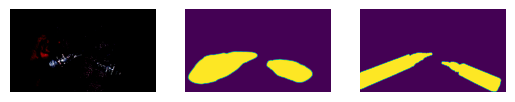

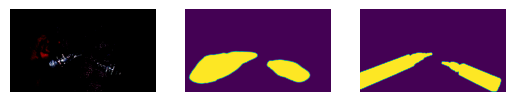

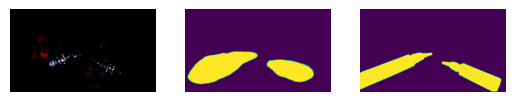

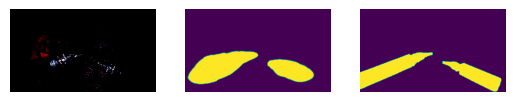

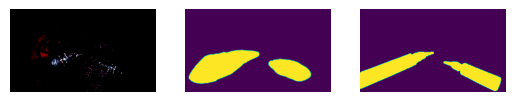

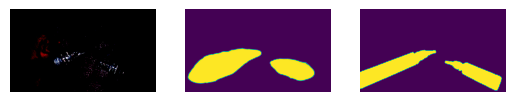

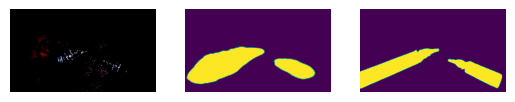

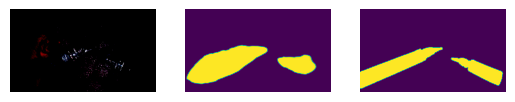

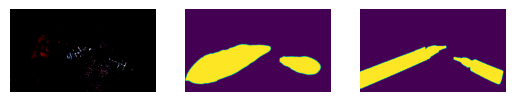

In [ ]:
segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader))
show_demo(segmentation_model_augmented, segmentation_test_dataloader)

<ipython-input-30-891b9376e63e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))


0.5930426323413849


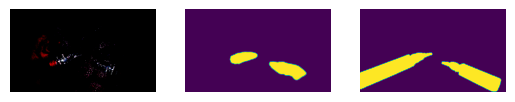

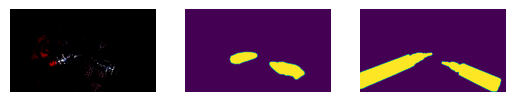

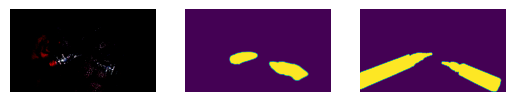

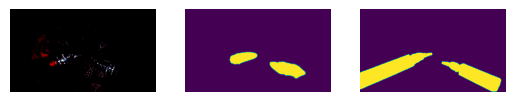

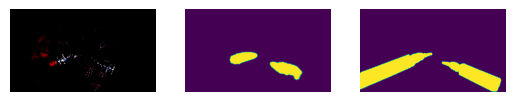

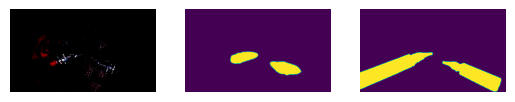

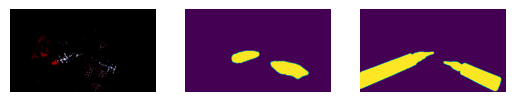

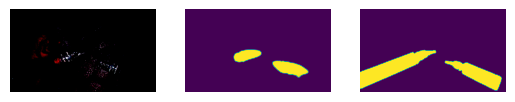

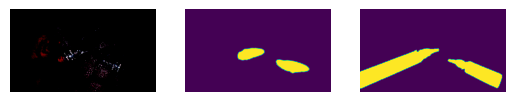

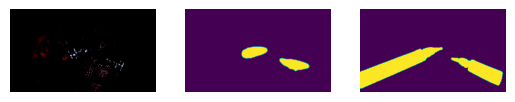

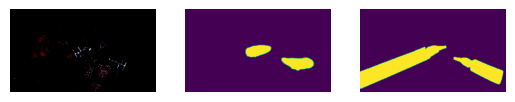

In [ ]:
segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

# Problem 2: Transfer Learning

In [ ]:
## Import VGG and FashionMNIST
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
from torchvision.datasets import FashionMNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Specify Batch Size
train_batch_size = 32
test_batch_size = 32

## Specify Image Transforms
img_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Download Datasets
train_data = FashionMNIST('./data', transform=img_transform, download=True, train=True)
test_data = FashionMNIST('./data', transform=img_transform, download=True, train=False)

## Initialize Dataloaders
training_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

### Model Initialization and Training/Fine-tuning

Complete the rest of the assignment in the notebook below.

In [ ]:
model_a = vgg16(pretrained=False)
model_a.classifier[6] = nn.Linear(4096, 10)
model_a = model_a.to(device)

learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer_a = optim.Adam(model_a.parameters(), lr=learning_rate)

In [ ]:
def train(model, optimizer, dataloader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")


In [ ]:
def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [ ]:
print("Training model_a (Randomly initialized)")
train(model_a, optimizer_a, training_dataloader, num_epochs=5)
print("Testing model_a")
test_accuracy = test(model_a, test_dataloader)


Training model_a (Randomly initialized)
Epoch [1/5], Loss: 0.4298
Epoch [2/5], Loss: 0.2370
Epoch [3/5], Loss: 0.1895
Epoch [4/5], Loss: 0.1550
Epoch [5/5], Loss: 0.1172
Testing model_a
Test Accuracy: 93.29%


In [ ]:
model_b = vgg16(pretrained=True)
for param in model_b.parameters():
    param.requires_grad = False
model_b.classifier[6] = nn.Linear(model_b.classifier[6].in_features, 10)
model_b.classifier[6].requires_grad = True
model_b = model_b.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_b = optim.Adam(model_b.classifier[6].parameters(), lr=0.0001)


In [ ]:
def train(model, optimizer, dataloader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")


In [ ]:
def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


In [ ]:
print("Training model_b (Pre-trained, fine-tuning last layer)")
train(model_b, optimizer_b, training_dataloader, num_epochs=5)
print("Testing model_b")
test_accuracy = test(model_b, test_dataloader)


Training model_b (Pre-trained, fine-tuning last layer)
Epoch [1/5], Loss: 0.7343
Epoch [2/5], Loss: 0.5277
Epoch [3/5], Loss: 0.4950
Epoch [4/5], Loss: 0.4791
Epoch [5/5], Loss: 0.4667
Testing model_b
Test Accuracy: 84.97%
